In [ ]:
# install the required libraries on Colab
!pip install pystan
!pip install prophet
!pip install hvplot
!pip install holoviews
!pip install jupyter_bokeh

In [ ]:
# imports
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import holoviews as hv
from prophet import Prophet
import hvplot.pandas
import datetime as dt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

### Data Cleaning for Prophet from trip_data.csv

In [ ]:
# Create df for encoded data.
from google.colab import files
uploaded = files.upload()

Saving trip_data.csv to trip_data (1).csv


In [ ]:
# read trip_data.csv from original data
trip_data_df = pd.read_csv("trip_data.csv",
                infer_datetime_format=True,
                parse_dates=True)

# preview df
display(trip_data_df)

,request_datetime,hvfhs_license_num,dispatching_base_num,originating_base_num,on_scene_datetime,pickup_datetime,dropoff_datetime,PULocationID,DOLocationID,trip_miles,...,sales_tax,congestion_surcharge,airport_fee,tips,driver_pay,shared_request_flag,shared_match_flag,access_a_ride_flag,wav_request_flag,wav_match_flag
0,2023-01-01 01:23:54,HV0003,B03404,B03404,2023-01-01 01:32:20,2023-01-01 01:34:04,2023-01-01 01:45:04,235,18,2.060,...,2.12,0.00,0.0,0.0,14.02,N,N,,N,N
1,2023-01-01 01:58:19,HV0003,B03404,B03404,2023-01-01 02:02:31,2023-01-01 02:02:53,2023-01-01 02:25:52,37,33,4.380,...,3.70,0.00,0.0,0.0,33.24,N,N,,N,N
2,2023-01-01 01:59:09,HV0003,B03404,B03404,2023-01-01 02:02:30,2023-01-01 02:04:02,2023-01-01 02:13:52,232,148,1.390,...,3.02,2.75,0.0,0.0,45.18,N,N,,N,N
3,2023-01-01 02:14:02,HV0003,B03404,B03404,2023-01-01 02:22:59,2023-01-01 02:23:19,2023-01-01 02:31:00,255,256,1.240,...,3.17,0.00,0.0,0.0,31.67,N,N,,N,N
4,2023-01-01 02:16:53,HV0003,B03404,B03404,2023-01-01 02:23:39,2023-01-01 02:24:02,2023-01-01 02:41:11,223,129,2.760,...,2.46,0.00,0.0,0.0,22.54,N,N,,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2023-12-31 22:08:52,HV0005,B03406,NaN,NaN,2023-12-31 22:20:42,2023-12-31 22:43:17,60,244,4.694,...,5.25,0.00,0.0,0.0,20.30,N,N,N,N,N
11996,2023-12-31 22:17:11,HV0005,B03406,NaN,NaN,2023-12-31 22:23:08,2023-12-31 22:44:52,188,165,4.222,...,3.82,0.00,0.0,0.0,17.96,N,N,N,N,N
11997,2023-12-31 22:30:20,HV0003,B03404,B03404,2023-12-31 22:34:13,2023-12-31 22:36:14,2023-12-31 22:59:56,225,148,5.470,...,2.25,2.75,0.0,0.0,20.55,N,N,N,N,N
11998,2023-12-31 22:31:17,HV0003,B03404,B03404,2023-12-31 22:33:22,2023-12-31 22:35:24,2023-12-31 23:23:07,65,50,6.140,...,3.05,2.75,0.0,0.0,39.12,N,N,N,N,Y


In [ ]:
# Create df for original data for Prophet time series
from google.colab import files
uploaded = files.upload()


Saving cleaned_data.csv to cleaned_data (1).csv


In [ ]:
# read cleaned_data.csv from main data clean
cleaned_data_df = pd.read_csv("cleaned_data.csv",
                  index_col=0)

# preview df
display(cleaned_data_df)

,rideshare_company,pickup_zone,dropoff_zone,trip_length_miles,trip_time_seconds,base_passenger_fare_dollars,tolls_dollars,black_car_fund_dollars,sales_tax_dollars,congestion_surcharge_dollars,...,good_fare,request_month,request_date,request_hour,request_minute,request_day_of_week,time_of_day,pickup_borough,dropoff_borough,tip_or_no_tip
0,Uber,University Heights/Morris Heights,Bedford Park,2.060,660,23.87,0.00,0.72,2.12,0.00,...,False,Jan,1,1,23,Sun,night,Bronx,Bronx,False
1,Uber,Bushwick South,Brooklyn Heights,4.380,1379,41.66,0.00,1.25,3.70,0.00,...,False,Jan,1,1,58,Sun,night,Brooklyn,Brooklyn,False
2,Uber,Two Bridges/Seward Park,Lower East Side,1.390,590,34.03,0.00,1.02,3.02,2.75,...,False,Jan,1,1,59,Sun,night,Manhattan,Manhattan,False
3,Uber,Williamsburg (North Side),Williamsburg (South Side),1.240,461,35.71,0.00,1.07,3.17,0.00,...,False,Jan,1,2,14,Sun,night,Brooklyn,Brooklyn,False
4,Uber,Steinway,Jackson Heights,2.760,1029,27.69,0.00,0.83,2.46,0.00,...,False,Jan,1,2,16,Sun,night,Queens,Queens,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,Lyft,Crotona Park East,Washington Heights South,4.694,1355,57.42,0.78,1.63,5.25,0.00,...,False,Dec,31,22,8,Sun,night,Bronx,Bronx,False
11996,Lyft,Prospect-Lefferts Gardens,Midwood,4.222,1304,47.12,0.00,1.18,3.82,0.00,...,False,Dec,31,22,17,Sun,night,Brooklyn,Brooklyn,False
11997,Uber,Stuyvesant Heights,Lower East Side,5.470,1422,25.40,0.00,0.70,2.25,2.75,...,False,Dec,31,22,30,Sun,night,Brooklyn,Brooklyn,False
11998,Uber,Downtown Brooklyn/MetroTech,Clinton West,6.140,2863,34.31,0.00,0.94,3.05,2.75,...,False,Dec,31,22,31,Sun,night,Brooklyn,Brooklyn,False


In [ ]:
# add the timeseries back to cleaned_df
cleaned_data_df = pd.concat([trip_data_df["request_datetime"], cleaned_data_df], axis=1)

# preview

cleaned_data_df



,request_datetime,rideshare_company,pickup_zone,dropoff_zone,trip_length_miles,trip_time_seconds,base_passenger_fare_dollars,tolls_dollars,black_car_fund_dollars,sales_tax_dollars,...,good_fare,request_month,request_date,request_hour,request_minute,request_day_of_week,time_of_day,pickup_borough,dropoff_borough,tip_or_no_tip
0,2023-01-01 01:23:54,Uber,University Heights/Morris Heights,Bedford Park,2.060,660,23.87,0.00,0.72,2.12,...,False,Jan,1,1,23,Sun,night,Bronx,Bronx,False
1,2023-01-01 01:58:19,Uber,Bushwick South,Brooklyn Heights,4.380,1379,41.66,0.00,1.25,3.70,...,False,Jan,1,1,58,Sun,night,Brooklyn,Brooklyn,False
2,2023-01-01 01:59:09,Uber,Two Bridges/Seward Park,Lower East Side,1.390,590,34.03,0.00,1.02,3.02,...,False,Jan,1,1,59,Sun,night,Manhattan,Manhattan,False
3,2023-01-01 02:14:02,Uber,Williamsburg (North Side),Williamsburg (South Side),1.240,461,35.71,0.00,1.07,3.17,...,False,Jan,1,2,14,Sun,night,Brooklyn,Brooklyn,False
4,2023-01-01 02:16:53,Uber,Steinway,Jackson Heights,2.760,1029,27.69,0.00,0.83,2.46,...,False,Jan,1,2,16,Sun,night,Queens,Queens,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,2023-12-31 22:08:52,Lyft,Crotona Park East,Washington Heights South,4.694,1355,57.42,0.78,1.63,5.25,...,False,Dec,31,22,8,Sun,night,Bronx,Bronx,False
11996,2023-12-31 22:17:11,Lyft,Prospect-Lefferts Gardens,Midwood,4.222,1304,47.12,0.00,1.18,3.82,...,False,Dec,31,22,17,Sun,night,Brooklyn,Brooklyn,False
11997,2023-12-31 22:30:20,Uber,Stuyvesant Heights,Lower East Side,5.470,1422,25.40,0.00,0.70,2.25,...,False,Dec,31,22,30,Sun,night,Brooklyn,Brooklyn,False
11998,2023-12-31 22:31:17,Uber,Downtown Brooklyn/MetroTech,Clinton West,6.140,2863,34.31,0.00,0.94,3.05,...,False,Dec,31,22,31,Sun,night,Brooklyn,Brooklyn,False


In [ ]:
cleaned_data_df.columns

Index(['request_datetime', 'rideshare_company', 'pickup_zone', 'dropoff_zone',
       'trip_length_miles', 'trip_time_seconds', 'base_passenger_fare_dollars',
       'tolls_dollars', 'black_car_fund_dollars', 'sales_tax_dollars',
       'congestion_surcharge_dollars', 'airport_fee_dollars', 'tip_dollars',
       'driver_pay_dollars', 'driver_total_pay_dollars', 'good_fare',
       'request_month', 'request_date', 'request_hour', 'request_minute',
       'request_day_of_week', 'time_of_day', 'pickup_borough',
       'dropoff_borough', 'tip_or_no_tip'],
      dtype='object')

,trip_length_miles,trip_time_seconds,base_passenger_fare_dollars,tolls_dollars,black_car_fund_dollars,sales_tax_dollars,congestion_surcharge_dollars,airport_fee_dollars,tip_dollars,driver_pay_dollars,driver_total_pay_dollars,request_date,request_hour,request_minute
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5.055372,1184.720333,24.501222,1.170466,0.740479,2.056529,1.079958,0.210813,1.135681,19.309817,20.445498,15.562500,13.476000,29.548333
std,5.830450,845.397846,20.476052,4.063950,0.660710,1.711446,1.339689,0.696965,3.279764,16.150156,17.643950,8.728169,6.492914,17.343689
min,0.000000,3.000000,-17.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-17.720000,-17.720000,1.000000,0.000000,0.000000
25%,1.590000,601.750000,11.630000,0.000000,0.340000,0.970000,0.000000,0.000000,0.000000,8.670000,9.100000,8.000000,9.000000,15.000000
50%,3.060000,962.000000,18.695000,0.000000,0.540000,1.580000,0.000000,0.000000,0.000000,14.495000,15.205000,15.000000,14.000000,30.000000
75%,6.270250,1543.000000,30.040000,0.000000,0.890000,2.570000,2.750000,0.000000,0.000000,24.410000,25.570000,23.000000,19.000000,45.000000
max,109.070000,10449.000000,442.060000,65.510000,12.230000,39.450000,5.500000,5.000000,99.240000,310.930000,410.170000,31.000000,23.000000,59.000000


,request_datetime,rideshare_company,pickup_zone,dropoff_zone,request_month,request_day_of_week,time_of_day,pickup_borough,dropoff_borough
count,12000,12000,12000,12000,12000,12000,12000,12000,12000
unique,11998,2,250,254,12,7,4,5,5
top,2023-12-24 18:38:21,Uber,LaGuardia Airport,Outside of NYC,Sep,Sat,afternoon,Manhattan,Manhattan
freq,2,8598,244,491,1001,2085,3437,4825,4825


Number of people who tip: 0.19858333333333333


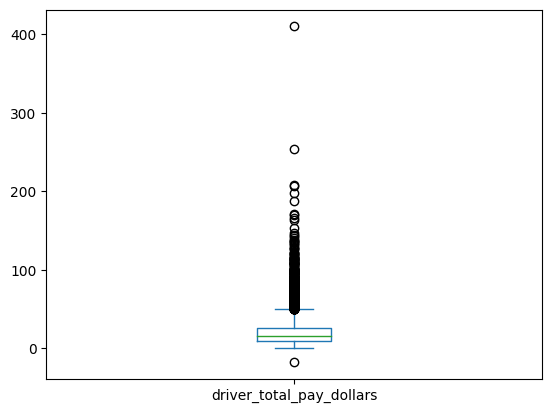

In [ ]:
# describe encoded data (numerical)
display(cleaned_data_df.describe())

# describe encoded data (categorical)
display(cleaned_data_df.describe(include=object))

# calculate how many people tip for all rides
print("Number of people who tip:", (12000-9617)/12000)

# box plot of top rides pay
pay_box_plot = cleaned_data_df["driver_total_pay_dollars"].plot.box()

# save box plot
plt.savefig("pay_box_plot.png")

In [ ]:
# calculate the frequency of most start and end points
print("% of all rides that end outside NYC", len(cleaned_data_df[cleaned_data_df["pickup_zone"] == "LaGuardia Airport"]) / len(cleaned_data_df))
print("% of all rides that begin at LaGuardia Airport", len(cleaned_data_df[cleaned_data_df["dropoff_zone"] == "Outside of NYC"]) / len(cleaned_data_df))

% of all rides that end outside NYC 0.02033333333333333
% of all rides that begin at LaGuardia Airport 0.040916666666666664


Isolate top paying round-trip rides

,trip_length_miles,trip_time_seconds,base_passenger_fare_dollars,tolls_dollars,black_car_fund_dollars,sales_tax_dollars,congestion_surcharge_dollars,airport_fee_dollars,tip_dollars,driver_pay_dollars,driver_total_pay_dollars,request_date,request_hour,request_minute
count,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000,115.000000
mean,16.761852,3400.017391,77.286522,3.972783,2.381391,7.415913,2.176087,2.282609,5.194957,64.798522,69.993478,15.043478,14.104348,28.243478
std,5.082328,1130.032246,22.516866,3.255997,0.688058,2.118612,1.122426,0.781167,8.543281,12.284914,16.184674,8.683915,5.223721,18.080517
min,1.590000,1239.000000,39.340000,0.000000,1.180000,3.490000,0.000000,0.000000,0.000000,51.680000,51.680000,1.000000,1.000000,0.000000
25%,13.263000,2608.500000,61.090000,0.000000,1.900000,5.960000,2.750000,2.500000,0.000000,55.610000,57.635000,8.000000,10.500000,11.000000
50%,17.593000,3364.000000,70.990000,6.000000,2.200000,6.890000,2.750000,2.500000,0.000000,60.460000,65.660000,15.000000,15.000000,30.000000
75%,19.200000,4010.000000,86.530000,6.550000,2.680000,8.430000,2.750000,2.500000,9.075000,70.260000,75.155000,22.000000,17.000000,42.000000
max,30.020000,6947.000000,153.440000,13.100000,4.480000,14.460000,2.750000,5.000000,40.000000,109.280000,132.910000,31.000000,23.000000,59.000000


,request_datetime,rideshare_company,pickup_zone,dropoff_zone,good_fare,request_month,request_day_of_week,time_of_day,pickup_borough,dropoff_borough,tip_or_no_tip
count,115,115,115,115,115,115,115,115,115,115,115
unique,115,2,42,35,1,12,7,4,4,4,2
top,2023-01-17 15:10:29,Uber,JFK Airport,JFK Airport,True,Aug,Thu,afternoon,Manhattan,Manhattan,False
freq,1,87,35,44,115,14,23,57,51,51,75


number of people who tip: 0.34782608695652173


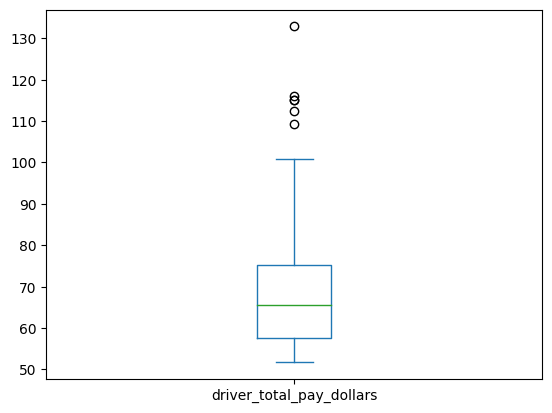

In [ ]:
# isolate round trips in cleaned data
top_round_trips = cleaned_data_df[cleaned_data_df[["pickup_zone", "dropoff_zone"]].apply(tuple, axis=1).isin(cleaned_data_df[["dropoff_zone", "pickup_zone"]].apply(tuple, axis=1))]

# calculate average total pay per ride
top_rides_df = top_round_trips.where(top_round_trips["good_fare"] == 1).dropna()

# isolate round trips
top_rides = top_rides_df[top_rides_df[["pickup_zone", "dropoff_zone"]].apply(tuple, axis=1).isin(top_rides_df[["dropoff_zone", "pickup_zone"]].apply(tuple, axis=1))]

# summary stats (numerical)
display(top_rides_df.describe())

# summary stats (categorical)
display(top_rides_df.describe(include=object))

# calculate how many people tip
print("number of people who tip:", (115-75)/115)

# box plot of top rides pay
top_pay_box_plot = top_rides_df["driver_total_pay_dollars"].plot.box()

# save box plot
plt.savefig("top_pay_box_plot.png")


In [ ]:
# find number of top 5% rides per day
len(top_rides_df) / 365


0.3150684931506849

In [ ]:
# find top 5 round trip rides

# reset index
top_rides_df["original_index"] = top_rides_df.index

# group by number of rows in group
top_five_df = top_rides_df.groupby(["pickup_zone", "dropoff_zone"]).nunique()

# sort by frequency, based on the count of the original index
top_five_df = top_five_df.sort_values("original_index", ascending=False)

# results
top_five_df.head(5)

request_datetime  \
pickup_zone               dropoff_zone                                     
Flatiron                  JFK Airport                                  5   
West Chelsea/Hudson Yards LaGuardia Airport                            3   
JFK Airport               Penn Station/Madison Sq West                 3   
                          Financial District North                     3   
                          Times Sq/Theatre District                    3   

                                                        rideshare_company  \
pickup_zone               dropoff_zone                                      
Flatiron                  JFK Airport                                   2   
West Chelsea/Hudson Yards LaGuardia Airport                             1   
JFK Airport               Penn Station/Madison Sq West                  2   
                          Financial District North                      1   
                          Times Sq/Theatre District                     1   

                                                        trip_length_miles  \
pickup_zone               dropoff_zone                                      
Flatiron                  JFK Airport                                   5   
West Chelsea/Hudson Yards LaGuardia Airport                             3   
JFK Airport               Penn Station/Madison Sq West                  3   
                          Financial District North                      3   
                          Times Sq/Theatre District                     3   

                                                        trip_time_seconds  \
pickup_zone               dropoff_zone                                      
Flatiron                  JFK Airport                                   5   
West Chelsea/Hudson Yards LaGuardia Airport                             3   
JFK Airport               Penn Station/Madison Sq West                  3   
                          Financial District North                      3   
                          Times Sq/Theatre District                     3   

                                                        base_passenger_fare_dollars  \
pickup_zone               dropoff_zone                                                
Flatiron                  JFK Airport                                             5   
West Chelsea/Hudson Yards LaGuardia Airport                                       3   
JFK Airport               Penn Station/Madison Sq West                            3   
                          Financial District North                                3   
                          Times Sq/Theatre District                               3   

                                                        tolls_dollars  \
pickup_zone               dropoff_zone                                  
Flatiron                  JFK Airport                               4   
West Chelsea/Hudson Yards LaGuardia Airport                         2   
JFK Airport               Penn Station/Madison Sq West              3   
                          Financial District North                  1   
                          Times Sq/Theatre District                 3   

                                                        black_car_fund_dollars  \
pickup_zone               dropoff_zone                                           
Flatiron                  JFK Airport                                        5   
West Chelsea/Hudson Yards LaGuardia Airport                                  3   
JFK Airport               Penn Station/Madison Sq West                       3   
                          Financial District North                           3   
                          Times Sq/Theatre District                          3   

                                                        sales_tax_dollars  \
pickup_zone               dropoff_zone                                      
Flatiron                  JFK Airport               

In [ ]:
# calculate the frequency of most common results
print("% of all rides that end at JFK Airport", len(top_rides_df[top_rides_df["dropoff_zone"] == "JFK Airport"]) / len(top_rides_df))
print("% of all rides that begin at JFK Airport", len(top_rides_df[top_rides_df["pickup_zone"] == "JFK Airport"]) / len(top_rides_df))

% of all rides that end at JFK Airport 0.3826086956521739
% of all rides that begin at JFK Airport 0.30434782608695654


## Prep data for Prophet

In [ ]:
# Create combined df of y-hat ("good_fare") and datetime of request
df = top_round_trips[["request_datetime", "good_fare"]]

# eliminate duplicated datetimes
df = df.groupby(df["request_datetime"]).mean()

# reset axis
df.reset_index(inplace=True)

# Label the columns ds and y so that the syntax is recognized by Prophet
df.columns=["ds", "y"]

# Drop an NaN values from the prophet_df DataFrame
df.dropna(inplace=True)

# Preview
df.head()

,ds,y
0,2023-01-01 01:23:54,0.0
1,2023-01-01 01:59:09,0.0
2,2023-01-01 02:14:02,0.0
3,2023-01-01 02:16:53,0.0
4,2023-01-01 04:06:01,0.0


In [ ]:
df.value_counts(subset="y")

y  
0.0    7139
1.0     115
dtype: int64

Prophet Code

In [ ]:
# Call the Prophet function, store as an object
model = Prophet()

# Fit the time-series model.
model.fit(df)

# Create a future dataframe to hold predictions
future_good_fare_trends = model.make_future_dataframe(periods=8760, freq="H")

# Make the predictions for the trend data using the future_mercado_trends DataFrame
# this creates values for the dates that have been created in the model
forecast_good_fare_trends = model.predict(future_good_fare_trends)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxmydk1i/sfeivt34.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphxmydk1i/bc79phtq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95772', 'data', 'file=/tmp/tmphxmydk1i/sfeivt34.json', 'init=/tmp/tmphxmydk1i/bc79phtq.json', 'output', 'file=/tmp/tmphxmydk1i/prophet_model1tz1mxqd/prophet_model-20240316150525.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:05:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:05:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


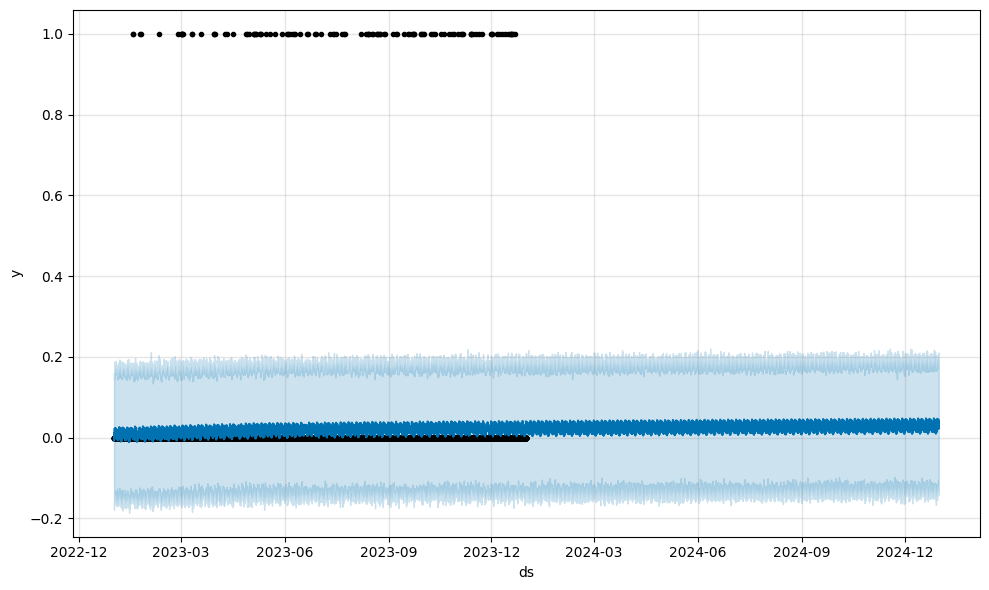

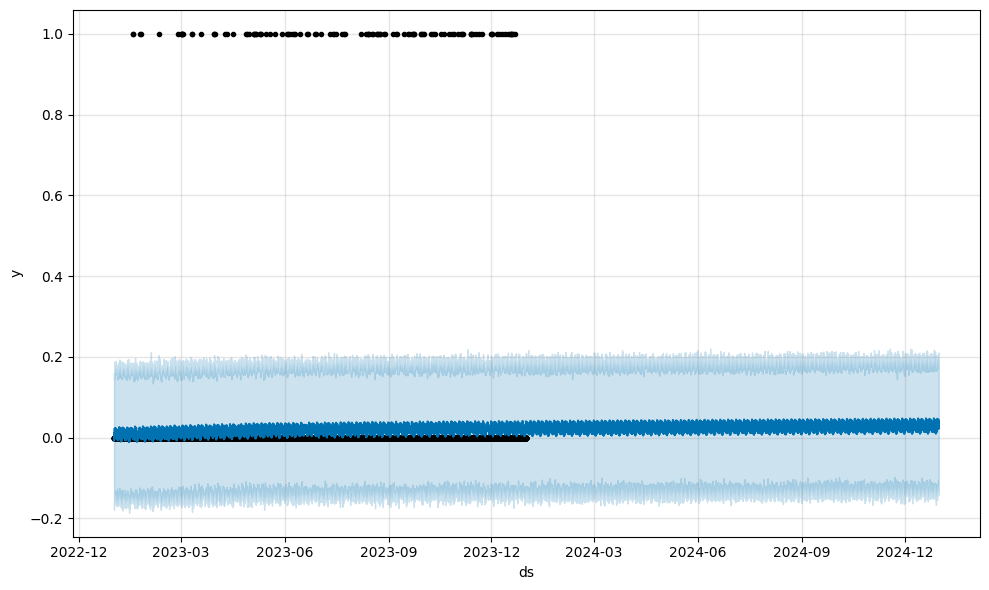

In [ ]:
# Plot the Prophet predictions for the Mercado trends data
# this plots the forecast
prophet_plot = model.plot(forecast_good_fare_trends)

prophet_plot.savefig("prophet_365.png")

prophet_plot

Timeseries components.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
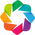

:NdOverlay   [Variable]
   :Curve   [ds]   (value)

In [ ]:
forecast_good_fare_trends.columns

# Set the index in the forecast_mercado_trends DataFrame to the ds datetime column
# it automatically did this, so I didn't have to run this code
forecast_good_fare_trends.set_index("ds", inplace=True)

# View the only the yhat,yhat_lower and yhat_upper columns from the DataFrame
forecast_good_fare_trends[["yhat", "yhat_lower", "yhat_upper"]]

# Holoviews extension to render hvPlots in Colab
hv.extension('bokeh')

# From the forecast_mercado_trends DataFrame, use hvPlot to visualize
forecast_good_fare_trends[["yhat", "yhat_lower", "yhat_upper"]].iloc[-8760:,:].hvplot(
    frame_width=800,
    x="ds",
    title="yhat Projections"
)


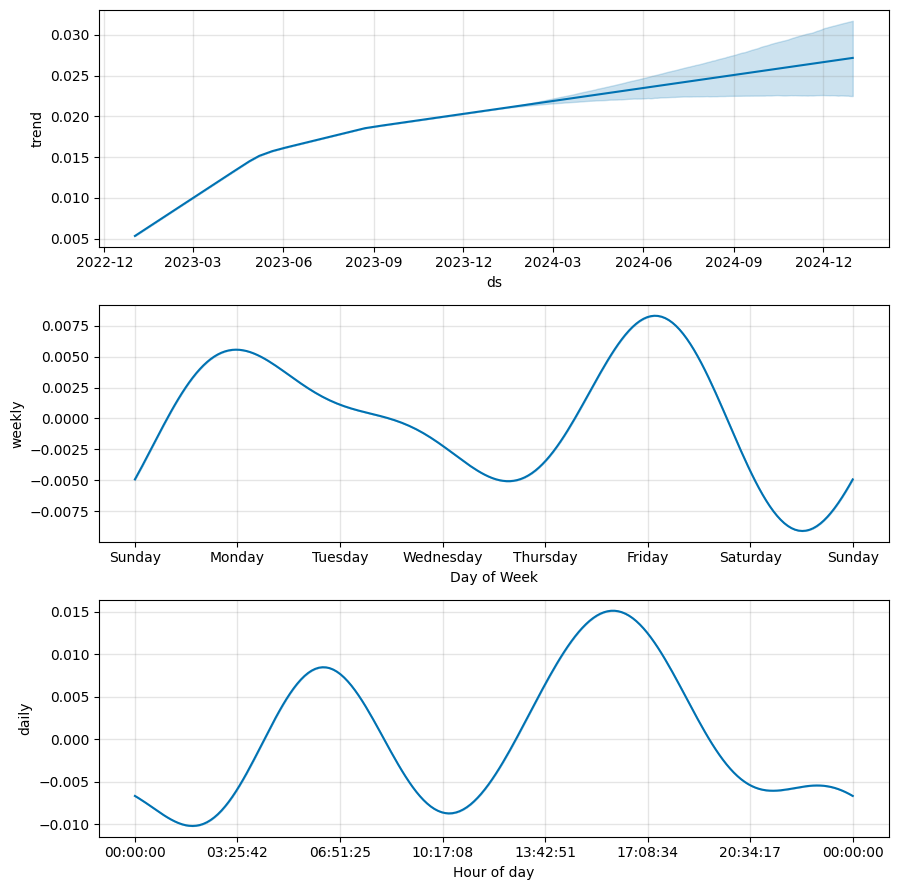

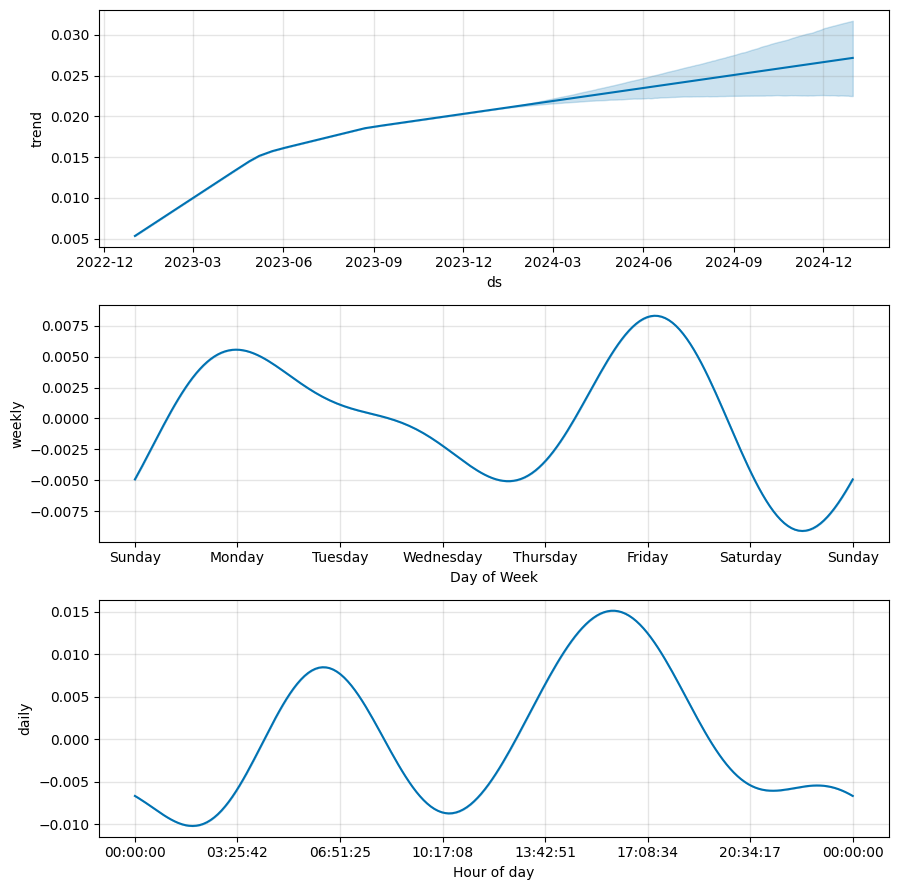

In [ ]:
# Reset the index in the forecast_mercado_trends DataFrame
forecast_good_fare_trends.reset_index(inplace=True)

# Use the plot_components function to visualize the forecast results
# for the forecast_canada DataFrame
components_plot = model.plot_components(forecast_good_fare_trends)

components_plot.savefig("prophet_components.png")

components_plot